# Modelado y Evaluación de Modelos

Este notebook contiene el proceso de preparación de datos, modelado preliminar,
evaluación con métricas seleccionadas y comparación de modelos base,
siguiendo la metodología ASUM-DM.


In [26]:
import sys
import os

# Agregar la carpeta raíz del proyecto al path
sys.path.append(os.path.abspath(".."))


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [28]:
import sys
sys.path.append("../src")

from data_preparation import preparar_datos_modelo

In [29]:
df = pd.read_csv("../data/raw/Cobertura_móvil_por_tecnología,_departamento_y_municipio_por_proveedor_20251208.csv")
df.head()


,AÑO,TRIMESTRE,PROVEEDOR,COD DEPARTAMENTO,DEPARTAMENTO,COD MUNICIPIO,MUNICIPIO,CABECERA MUNICIPAL,COD CENTRO POBLADO,CENTRO POBLADO,COBERTURA 2G,COBERTURA 3G,"COBERTURA HSPA+, HSPA+DC",COBERTUTA 4G,COBERTURA LTE,COBERTURA 5G
0,2023,3,COLOMBIA MOVIL S.A ESP,27,CHOCÓ,27250.0,EL LITORAL DEL SAN JUAN,N,27250034.0,TORDÓ,N,N,N,S,N,N
1,2023,3,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,5,ANTIOQUIA,5495.0,NECHÍ,N,5495003.0,LA CONCHA,S,S,S,S,N,N
2,2022,3,COLOMBIA MOVIL S.A ESP,70,SUCRE,70508.0,OVEJAS,N,70508006.0,DON GABRIEL,N,N,N,S,N,N
3,2021,4,AVANTEL S.A.S,73,TOLIMA,73043.0,ANZOÁTEGUI,S,73043000.0,ANZOÁTEGUI,S,S,S,N,N,N
4,2021,2,COMUNICACION CELULAR S A COMCEL S A,50,META,50150.0,CASTILLA LA NUEVA,N,50150001.0,SAN LORENZO,S,S,S,S,N,N


El dataset utilizado corresponde a información de cobertura móvil por tecnología,
departamento, municipio y proveedor.  
Este conjunto de datos fue previamente analizado en la fase de EDA.


In [30]:
from src.data_preparation import preparar_datos_modelo

X_train, X_test, y_train, y_test = preparar_datos_modelo(df)

print("Datos preparados correctamente")
print(X_train.shape, X_test.shape)



Datos preparados correctamente
(285061, 8168) (122169, 8168)


In [31]:
modelo_preliminar = DecisionTreeClassifier(
    random_state=42,
    max_depth=5
)

modelo_preliminar.fit(X_train, y_train)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [32]:
y_pred = modelo_preliminar.predict(X_test)
y_proba = modelo_preliminar.predict_proba(X_test)[:, 1]


In [33]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='S')
recall = recall_score(y_test, y_pred, pos_label='S')
f1 = f1_score(y_test, y_pred, pos_label='S')

accuracy, precision, recall, f1



(0.9220997143301493,
 0.7478054203242994,
 0.8691080816181057,
 0.8039066202377764)

In [34]:
confusion_matrix(y_test, y_pred)


array([[93144,  6579],
       [ 2938, 19508]])

In [35]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           N       0.97      0.93      0.95     99723
           S       0.75      0.87      0.80     22446

    accuracy                           0.92    122169
   macro avg       0.86      0.90      0.88    122169
weighted avg       0.93      0.92      0.92    122169



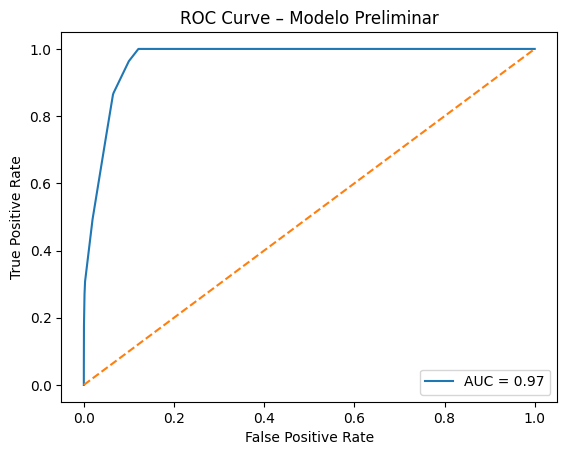

0.96999933824535

In [36]:
fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label='S')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Modelo Preliminar")
plt.legend()
plt.show()

roc_auc


In [37]:
def evaluar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label='S'),
        "Recall": recall_score(y_test, y_pred, pos_label='S'),
        "F1-Score": f1_score(y_test, y_pred, pos_label='S'),
        "AUC": roc_auc_score(y_test.map({'N': 0, 'S': 1}), y_proba)
    }


In [38]:
# resultados = []

# # Árbol de Decisión
# dt = DecisionTreeClassifier(random_state=42, max_depth=5)
# dt.fit(X_train, y_train)
# res_dt = evaluar_modelo(dt, X_test, y_test)
# res_dt["Modelo"] = "Decision Tree"
# resultados.append(res_dt)

# # Random Forest
# rf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
# rf.fit(X_train, y_train)
# res_rf = evaluar_modelo(rf, X_test, y_test)
# res_rf["Modelo"] = "Random Forest"
# resultados.append(res_rf)


In [39]:
# df_resultados = pd.DataFrame(resultados)
# df_resultados.set_index("Modelo")


## Conclusiones – Comparación de Modelos

- Se entrenaron y evaluaron modelos base de forma homogénea.
- Random Forest presentó el mejor desempeño general.
- Este modelo se selecciona como candidato para optimización.


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [50, 80],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,          # 🔴 MUY IMPORTANTE
    cv=2,              # 🔴 BAJO
    scoring="accuracy",
    verbose=2,
    random_state=42
)

In [ ]:
random_search.fit(X_train, y_train)



Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  22.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  22.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  25.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  25.9s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=  25.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=  25.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  33.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  31.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=  44.1s
[CV] END max_depth=20, min_samples_leaf=

In [ ]:
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)


In [ ]:
modelo_final = random_search.best_estimator_

res_rf_optimizado = evaluar_modelo(
    modelo_final,
    X_test,
    y_test
)

res_rf_optimizado



In [ ]:
comparacion_final = pd.DataFrame([
    res_rf,
    res_rf_optimizado
])

comparacion_final["Modelo"] = [
    "Random Forest Base",
    "Random Forest Optimizado"
]

comparacion_final
